<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/eda_nytimes-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYTimes COVID-19 EDA

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd

from scipy.signal import savgol_filter

from urllib.request import urlopen
import json

from time import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [47]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    return dft

In [48]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [50]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340762 entries, 0 to 340761
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    340762 non-null  datetime64[ns]
 1   county  340762 non-null  category      
 2   state   340762 non-null  category      
 3   fips    337294 non-null  category      
 4   cases   340762 non-null  int32         
 5   deaths  340762 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 6.5 MB


# import census and GeoJSON data

We want to calculate ratios comparing the number of cases (or deaths) to the population and/or area of the county. Since the population density varies wildly per county, relying on just the absolute number of reported cases could be misleading.

In [72]:
pop_df = optimize(pd.read_csv('data/pop_df.csv', dtype={'fips':'str'}))
# with urlopen('https://raw.githubusercontent.com/jydiw/nyt-covid-19-data/master/data/pop_df.csv') as response:
#     pop_df = optimize(pd.read_csv(response, dtype={'fips':'str'}))
pop_df.head()

,state,county,tot_pop,fips,per_white,area,lon,lat,pop_per_area,per_gop,per_dem,total_votes,per_votes
0,Alabama,Autauga,55869,01001,0.762623,594.435974,-86.641197,32.536152,93.986572,0.734358,0.239569,24661.0,0.441408
1,Alabama,Baldwin,223234,01003,0.874410,1589.784058,-87.723953,30.725863,140.417816,0.773515,0.195653,94090.0,0.421486
2,Alabama,Barbour,24686,01005,0.491534,884.875977,-85.389244,31.867889,27.897696,0.522714,0.466603,10390.0,0.420886
3,Alabama,Bibb,22394,01007,0.767661,622.581970,-87.124962,32.996456,35.969563,0.769662,0.214220,8748.0,0.390640
4,Alabama,Blount,57826,01009,0.958254,644.776001,-86.569756,33.985249,89.683861,0.898519,0.084699,25384.0,0.438972


In [73]:
pop_df.sort_values(by='tot_pop').iloc[[0, -1]]

,state,county,tot_pop,fips,per_white,area,lon,lat,pop_per_area,per_gop,per_dem,total_votes,per_votes
548,Hawaii,Kalawao,86,15005,0.279070,11.991000,-156.951126,21.175037,7.172046,NaN,NaN,NaN,NaN
204,California,Los Angeles,10039107,06037,0.707066,4057.884033,-118.216835,34.357796,2473.975830,0.233887,0.714072,2652072.0,0.264174


In [74]:
pop_df.sort_values(by='pop_per_area').iloc[[0, -1]]

,state,county,tot_pop,fips,per_white,area,lon,lat,pop_per_area,per_gop,per_dem,total_votes,per_votes
95,Alaska,Yukon-Koyukuk Census Area,5230,02290,0.235373,145504.78125,-151.390030,65.508743,0.035944,0.289615,0.574946,1868.0,0.357170
1858,New York,New York,1628706,36061,0.645742,22.82900,-73.962898,40.783318,71343.726562,0.099659,0.871675,591368.0,0.363091


There are several things to consider:

- Raw numbers will show New York City and Los Angeles County with the highest numbers, all other factors being equal.
- Reporting cases as a percentage (or as we'll use later, a per 100k) would better reflect the severity of infections.
- However, a higher population density would likely make it easier to transmit the disease to another person. Looking at the day-to-day change in new cases could allow us to see how quickly the disease is spreading.

In [58]:
nyt_df = nyt_df[nyt_df['county'] != 'Unknown']
list(set(nyt_df['county']) - set(pop_df['county']))

['San Lorenzo',
 'Moca',
 'Guanica',
 'Toa Alta',
 'Morovis',
 'Corozal',
 'Culebra',
 'San German',
 'Hatillo',
 'Aguada',
 'Patillas',
 'Ceiba',
 'Barranquitas',
 'Juana Diaz',
 'Rincon',
 'Coamo',
 'Penuelas',
 'Loiza',
 'Toa Baja',
 'Vega Alta',
 'Maricao',
 'Lajas',
 'Fajardo',
 'Ciales',
 'Gurabo',
 'Las Marias',
 'Manati',
 'Dorado',
 'Quebradillas',
 'Jayuya',
 'Las Piedras',
 'Villalba',
 'Maunabo',
 'Guayanilla',
 'Arroyo',
 'Utuado',
 'Juncos',
 'Lares',
 'Tinian',
 'Mayaguez',
 'Sabana Grande',
 'Yabucoa',
 'Florida',
 'Adjuntas',
 'Catano',
 'Salinas',
 'Humacao',
 'Aguadilla',
 'Cabo Rojo',
 'Naranjito',
 'Cayey',
 'Santa Isabel',
 'Guayama',
 'Trujillo Alto',
 'Ponce',
 'Luquillo',
 'Camuy',
 'Vieques',
 'Comerio',
 'Bayamon',
 'Cidra',
 'Vega Baja',
 'Orocovis',
 'Guaynabo',
 'Arecibo',
 'Caguas',
 'Hormigueros',
 'Canovanas',
 'Naguabo',
 'Anasco',
 'Aguas Buenas',
 'Saipan',
 'Yauco',
 'Barceloneta',
 'Isabela',
 'Carolina',
 'San Sebastian',
 'Aibonito']

The NYTimes dataset does not include diacritical marks for the names of Puerto Rico's municipios. In the interest of cultural accuracy, we will preserve them when merging with `pop_df`. 

The NYTimes dataset deals with New York City, Kansas City, and Joplin as their own entities. As such, they do not have valid `fips` codes; we must add our custom `fips` from our earlier census EDA.

In [59]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = 'nyc'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = 'kc'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = 'jm'
nyt_df['fips'] = nyt_df['fips'].astype('category')

# merge `nyt_df` and `pop_df` for feature engineering

In [60]:
pop_df[pop_df['state'] == 'Puerto Rico']['county'].unique()

array([], dtype=object)

In [75]:
tick = time()

df = nyt_df.merge(pop_df, on='fips', suffixes=('_x','')).drop(['county_x', 'state_x'], axis=1)

# person density
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['tot_pop'], axis=0) * 100_000
# df[['cases_per_100k', 'deaths_per_100k']] = df[['cases_per_100k', 'deaths_per_100k']].round(4)

df = df.sort_values(by=['date', 'fips'])

tock = time()
print(tock - tick)
print(df.shape)
df.head()

0.2124319076538086
(331910, 18)


,date,fips,cases,deaths,state,county,tot_pop,per_white,area,lon,lat,pop_per_area,per_gop,per_dem,total_votes,per_votes,cases_per_100k,deaths_per_100k
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,48.046917,393.855042,0.376202,0.542634,309496.0,0.376478,0.121642,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,48.046917,393.855042,0.376202,0.542634,309496.0,0.376478,0.121642,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,48.046917,393.855042,0.376202,0.542634,309496.0,0.376478,0.121642,0.0
178,2020-01-24,17031,1,0,Illinois,Cook,5150233,0.654355,945.325989,-87.817429,41.839622,5448.102539,0.214193,0.743758,2055215.0,0.399053,0.019417,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,48.046917,393.855042,0.376202,0.542634,309496.0,0.376478,0.121642,0.0


In [63]:
list(set(df['county']) - set(pop_df['county']))

[]

In [64]:
df.to_csv('data/df-no-trends.csv', index=False)

In [65]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

In [76]:
def add_change_cols(df, cols, pre='new_', clip=True):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    return (df, cols_d)

In [77]:
ding = time()
df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
df, new_cols_7sg = add_savgol_cols(df, new_cols)
df, delta_new_cols = add_change_cols(df, new_cols, pre='delta_', clip=False)
df, delta_new_cols_7sg = add_savgol_cols(df, delta_new_cols)
dong = time()
print(dong - ding)
print(df.columns)
df.head()

16.117911338806152
Index(['date', 'fips', 'cases', 'deaths', 'state', 'county', 'tot_pop',
       'per_white', 'area', 'lon', 'lat', 'pop_per_area', 'per_gop', 'per_dem',
       'total_votes', 'per_votes', 'cases_per_100k', 'deaths_per_100k',
       'new_cases', 'new_deaths', 'new_cases_per_100k', 'new_deaths_per_100k',
       'new_cases_7sg', 'new_deaths_7sg', 'new_cases_per_100k_7sg',
       'new_deaths_per_100k_7sg', 'delta_new_cases', 'delta_new_deaths',
       'delta_new_cases_per_100k', 'delta_new_deaths_per_100k',
       'delta_new_cases_7sg', 'delta_new_deaths_7sg',
       'delta_new_cases_per_100k_7sg', 'delta_new_deaths_per_100k_7sg'],
      dtype='object')


,date,fips,cases,deaths,state,county,tot_pop,per_white,area,lon,...,new_cases_per_100k_7sg,new_deaths_per_100k_7sg,delta_new_cases,delta_new_deaths,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg
0,2020-01-21,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,2020-01-22,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,2020-01-23,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
178,2020-01-24,17031,1,0,Illinois,Cook,5150233,0.654355,945.325989,-87.817429,...,-0.003467,0.0,0.0,0.0,0.0,0.0,-0.178571,0.0,-0.003467,0.0
3,2020-01-24,53061,1,0,Washington,Snohomish,822083,0.769645,2087.272949,-121.692780,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


In [78]:
df.to_csv('data/df.csv', index=False)

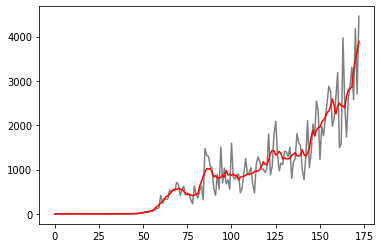

In [70]:
county = 'Los Angeles'
temp_df = df[df['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_7sg', data=temp_df, color='red')

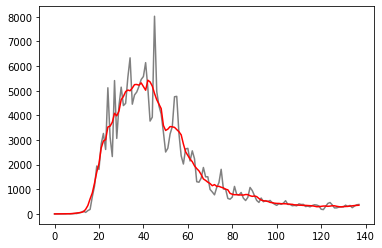

In [71]:
county = 'New York City'
temp_df = df[df['county'] == county]
plt.plot(np.arange(len(temp_df)), 'new_cases', data=temp_df, color='gray')
plt.plot(np.arange(len(temp_df)), 'new_cases_7sg', data=temp_df, color='red')